---
---
# Audio Classification using DNN & CNN
---
---

In this Demo we will be introducing the transfer learning concept

Please use the GPU in Google Colab to significantly speed up the training time for machine learning models that use TensorFlow, PyTorch, or other frameworks. Google Colab provides free access to GPUs and TPUs to accelerate computational tasks. Here's how you can set up and use a GPU in Google Colab:

 **Change the runtime type to GPU**:
   - Go to the menu at the top of the notebook and click on `Runtime`.
   - Select `Change runtime type` from the dropdown menu.
   - A dialog box will appear. Under "Hardware accelerator," choose `GPU` from the dropdown menu.
   - Click `Save` to apply the changes. This will restart your Colab environment with GPU support.


## Setup

In [1]:
!pip install datasets
!pip install joblib
!pip install librosa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


## Libraries Imports

In [2]:
#import tensorflow and keras
import tensorflow as tf
import keras
from keras import layers, models, datasets, applications

#import pandas and matplotlib for accurcy visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import time
import random

# Set random seed
tf.keras.utils.set_random_seed(42)


In [3]:
# Ensure GPU availability
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPUs found. Running on CPU instead.")


No GPUs found. Running on CPU instead.


Convolutional Neural Networks (CNNs) have long been the cornerstone of modern image processing and computer vision, but their application extends far beyond just analyzing visual data. One particularly interesting area where CNNs have shown great promise is in the classification of speech commands. This task involves recognizing spoken words or phrases from audio inputs, which is a critical component in developing interactive voice-controlled systems like virtual assistants, voice-activated home automation, and hands-free computing.

### The Appeal of CNNs for Speech Command Recognition

CNNs are well-suited for speech command recognition due to their ability to extract hierarchical features from data. While traditionally used for images, the same principles can be applied to spectrograms (visual representations of the frequency spectrum of sounds over time) derived from audio signals. Here's why CNNs are effective:

1. **Feature Extraction**: CNNs automatically learn to identify important features without needing explicit instructions on what to look for. In the context of speech commands, these features might include variations in pitch, tone, and intensity of the spoken words.

2. **Translation Invariance**: Once a CNN learns a feature in one part of the data, it can recognize that feature anywhere. This is invaluable in speech recognition, where the same word may start at different times or be spoken at different speeds.

3. **Temporal Structure Handling**: Although CNNs are inherently better at handling spatial data, when applied to spectrograms, they can effectively capture temporal dependencies, recognizing patterns over time, crucial for understanding speech.


## Loading Data

## [Google Speech Commands V1 Dataset](https://arxiv.org/abs/1804.03209)

A dataset used as a popular benchmark for training and evaluating deep learning models built for solving the KWS task.
The dataset consists of a total of 60,973 audio files, each of 1 second duration,
divided into ten classes of keywords ("Yes", "No", "Up", "Down", "Left", "Right", "On",
"Off", "Stop", and "Go"), a class for silence, and an unknown class to include the false
positive. We load the dataset from [Hugging Face Datasets](https://github.com/huggingface/datasets).
This can be easily done with the `load_dataset` function.

In [4]:
from datasets import load_dataset

speech_commands_v1 = load_dataset("superb", "ks", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/51094 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6798 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3081 [00:00<?, ? examples/s]

The dataset has the following fields:

- **file**: the path to the raw .wav file of the audio
- **audio**: the audio file sampled at 16kHz
- **label**: label ID of the audio utterance

In [5]:
print(speech_commands_v1)

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'label'],
        num_rows: 51094
    })
    validation: Dataset({
        features: ['file', 'audio', 'label'],
        num_rows: 6798
    })
    test: Dataset({
        features: ['file', 'audio', 'label'],
        num_rows: 3081
    })
})


## Data Pre-processing

For the sake of demonstrating the workflow, in this notebook we only take
small stratified balanced splits (60%) of the train as our training and test sets.
We can easily split the dataset using the `train_test_split` method which expects
the split size and the name of the column relative to which you want to stratify.

Post splitting the dataset, we remove the `unknown` and `silence` classes and only
focus on the ten main classes. The `filter` method does that easily for you.

In [6]:
speech_commands_v1 = speech_commands_v1["train"].train_test_split(
    train_size=0.6, test_size=0.4, stratify_by_column="label"
)

speech_commands_v1 = speech_commands_v1.filter(
    lambda x: x["label"]
    != (
        speech_commands_v1["train"].features["label"].names.index("_unknown_")
        and speech_commands_v1["train"].features["label"].names.index("_silence_")
    )
)


print(speech_commands_v1)

Filter:   0%|          | 0/30656 [00:00<?, ? examples/s]

Filter:   0%|          | 0/20438 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'label'],
        num_rows: 30652
    })
    test: Dataset({
        features: ['file', 'audio', 'label'],
        num_rows: 20436
    })
})


Additionally, you can check the actual labels corresponding to each label ID.

In [7]:
labels = speech_commands_v1["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

print(id2label)

{'0': 'yes', '1': 'no', '2': 'up', '3': 'down', '4': 'left', '5': 'right', '6': 'on', '7': 'off', '8': 'stop', '9': 'go', '10': '_silence_', '11': '_unknown_'}


**Preprocessing**: The raw audio data is first converted into a format suitable for CNN processing. This often involves transforming the audio into a spectrogram, which turns the speech into a 2D image-like format where one axis represents time and the other represents frequency, while intensity indicates the energy or amplitude at each point.

### To convert audio files to spectrograms:


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import librosa
import librosa.display

def audio_to_spectrogram(audio, sample_rate):
    # Use librosa to convert audio waveform to spectrogram
    S = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    S_DB = librosa.power_to_db(S, ref=np.max)
    return S_DB

def plot_spectrogram(S_DB):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_DB, sr=16000, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()

### You can convert and display the first few audio files:


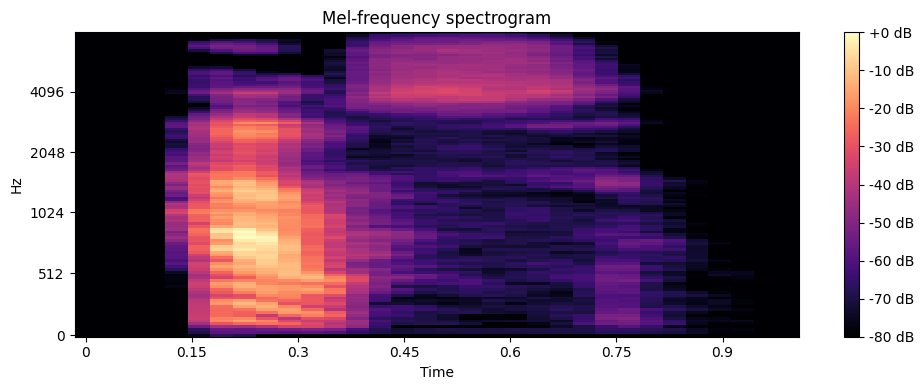

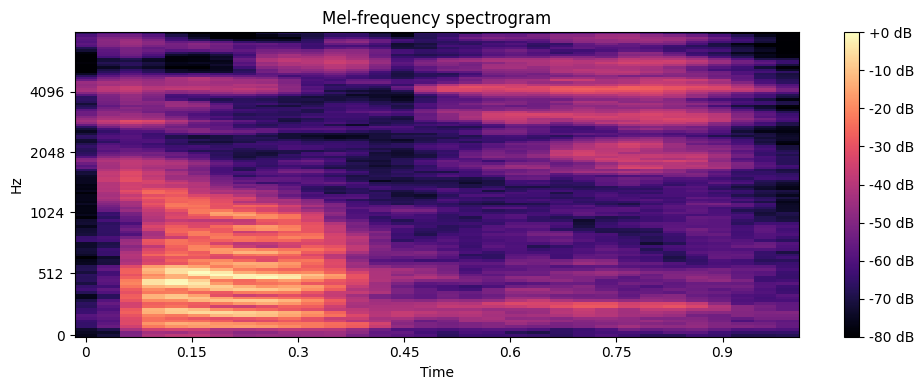

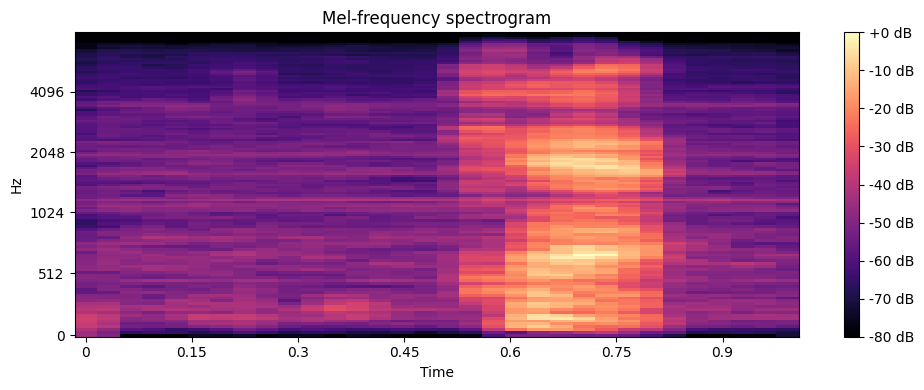

In [9]:
for i in range(3):
    audio = speech_commands_v1['train'][i]['audio']['array']
    sample_rate = speech_commands_v1['train'][i]['audio']['sampling_rate']
    S_DB = audio_to_spectrogram(audio, sample_rate)
    plot_spectrogram(S_DB)

In [10]:
from tqdm import tqdm  # Import tqdm

def prepare_dataset(data):
    X = []
    y = []

    # Add tqdm wrapper around the loop to display the progress bar
    for sample in tqdm(data, desc="Processing audio files"):
        audio = sample['audio']['array']
        label = sample['label']
        sr = sample['audio']['sampling_rate']

        # Convert audio to spectrogram
        S_DB = audio_to_spectrogram(audio, sr)

        # Normalize the spectrogram
        S_DB_norm = (S_DB - np.min(S_DB)) / (np.max(S_DB) - np.min(S_DB))

        # Resize spectrogram to a fixed size (64x64)
        S_DB_resized = librosa.util.fix_length(S_DB_norm, size=64, axis=1)  # Note: Adjust the size according to your CNN input
        S_DB_resized = librosa.util.fix_length(S_DB_resized, size=64, axis=0)

        X.append(S_DB_resized)
        y.append(label)

    return np.array(X), np.array(y)

X_train, y_train = prepare_dataset(speech_commands_v1['train'])
X_test, y_test = prepare_dataset(speech_commands_v1['test'])

Processing audio files:  54%|█████▎    | 16450/30652 [03:09<02:24, 98.20it/s]<ipython-input-10-700d3a776283>:17: RuntimeWarning: invalid value encountered in divide
  S_DB_norm = (S_DB - np.min(S_DB)) / (np.max(S_DB) - np.min(S_DB))
Processing audio files: 100%|██████████| 20436/20436 [03:55<00:00, 86.79it/s] 


In [11]:
print('classes:', np.unique(y_train), 'Num of classes:', len(np.unique(y_train)))

classes: [ 0  1  2  3  4  5  6  7  8  9 11] Num of classes: 11


In [12]:
print('Image shape', X_train.shape)

Image shape (30652, 64, 64)


## Modeling

Here’s a simple CNN model

In [13]:
def build_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [14]:
model = build_model(input_shape=(64,64,1), num_classes=12)

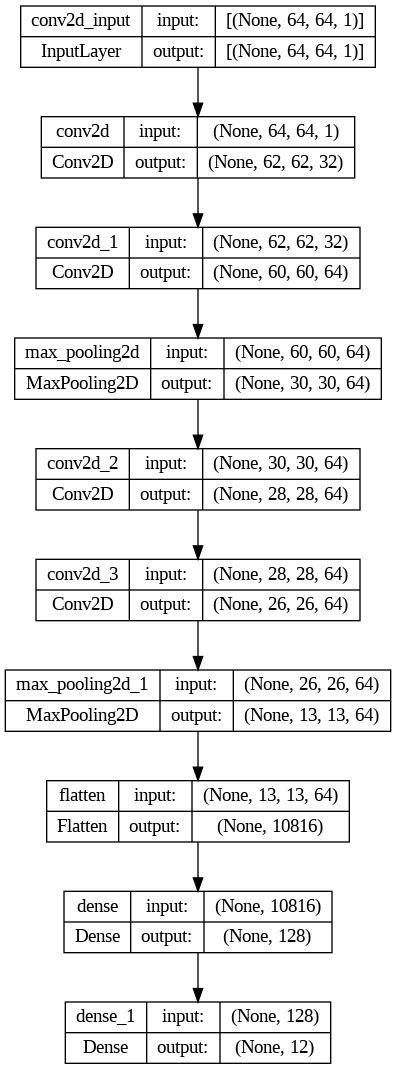

In [15]:
# Display the model's architecture
keras.utils.plot_model(model, "audio_model.png", show_shapes=True)

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

history = model.fit(X_train, y_train, batch_size=1000, validation_split=0.2, epochs=10, callbacks=[early_stopping])

## Evaluate the Model

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)